In [1]:
pip install circe-py

Note: you may need to restart the kernel to use updated packages.


# **Cis co-accessibility network with Circe**

In [1]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp

#### Create fake AnnData

This data doesn't contain strong correlation between fake regions, the score will then be low. 

It will still allow us to demonstrate how to use Circe. :)

In [2]:
atac = sc.datasets.blobs(n_centers=10, n_variables=2_000, n_observations=300, random_state=0)
atac.X = np.random.poisson(lam=2, size=atac.X.shape)
cell_names = [f"cell_{i}" for i in range(1, atac.shape[0]+1)]
# number of chr_start_end region names
region_names = [[f"chr{i}_{str(j)}_{str(j+150)}" 
                 for j in range(1, 10000*400+1, 10000)] 
                for i in range(1, 6)]
regions_names = [item for sublist in region_names for item in sublist]
atac.var_names = regions_names
atac.obs_names = cell_names

#### Filter the data

In [3]:
sc.pp.filter_genes(atac, min_cells=1)
sc.pp.filter_cells(atac, min_genes=1)
atac

AnnData object with n_obs × n_vars = 300 × 2000
    obs: 'blobs', 'n_genes'
    var: 'n_cells'

### 1. Add region position in AnnData.obs

Let's first run `add_region_infos` that will <font color=#F98128>**add coordinate annotations**</font> `chr`, `start`, `end` as columns in `atac.var` slot

In [4]:
atac = ci.add_region_infos(atac)

### 2. Compute pseudocells

<font color=#F98128>**Compute metacells**</font> is an interesting step to reduce sparsity in our data, since scATAC-seq data have usually a lot of dropouts.

In [5]:
metacells = ci.metacells.compute_metacells(atac)

/home/rtrimbou/miniconda3/envs/circe/lib/python3.12/site-packages/circe/metacells.py:181: ImplicitModificationWarning: Setting element `.obsm['X_lsi']` of view, initializing view as actual.
  adata.obsm["X_lsi"] = X_lsi


Output()

### 3. Calculate co-accessibility

#### 3.A. Human datasets

We can finally <font color=#F98128>**compute all the cis co-accessibility scores**</font> ! <br>
The default way is to <font color='#50B848'>**indicate your organism**</font> if among the one known by Circe.<br>
The atac network is stored automatically as a sparse matrix in `atac.varp["atac_network"]`

In [6]:
ci.compute_atac_network(
    atac, #metacells,
    organism="human",
)
atac.varp["atac_network"]

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 116720 stored elements and shape (2000, 2000)>

#### 3.B. Other organisms

##### If your organism is **not** <font color=#50B848>"human"</font>, <font color=#50B848>"mouse"</font> or <font color=#50B848>"drosophila"</font>, human default values will be used for:
`s`, `window_size` and `distance_constraint`.
Distance constraint is usually half of the window size.

If you know their values,
you can also specify yourself the following parameters that are organism-specific.

In [7]:
window_size = 100_000
distance_constraint=50_000
s = 0.85
ci.compute_atac_network(
    atac, #metacells,
    window_size=window_size,
    s=s,
    distance_constraint=distance_constraint,
    unit_distance = 1000,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=100
)

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


#### 3.C. Use of sparse matrix

1. Circe can also work with `sparse covariance matrix`.<br>

In [8]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

2. Connections can also be stored externally from your `AnnData` object using `sliding_graphical_lasso`.

In [9]:
final_score = ci.sliding_graphical_lasso(
    atac,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=True
)
atac.varp['atac_network'] = final_score

Output()

/home/rtrimbou/miniconda3/envs/circe/lib/python3.12/site-packages/circe/circe.py:887: UserWarning: 
                No organism, nor value passed for the parameters: ['window_size', 'distance_constraint', 's'],
                using default values.
                The default values are defined from human and mouse data,
                you might want to change them if you are working with
                another organisms.

                Default values used:
                {'window_size': 500000, 'distance_constraint': 250000, 's': 0.75}

                You can check how to define them in /{citation/}.
                
  warnings.warn(


Output()

Alpha coefficient calculated : 0.22330802977304073


Output()

Averaging co-accessibility scores across windows...
Done !


### 4. Extract connections

#### 4.A.Get the whole genome cis-coaccessible network

You can <font color='#F98128'>**extract connections**</font> from the atac.varp slot (sparse matrix), as a `DataFrame object` with `extract_atac_links`.

In [10]:
circe_network = ci.extract_atac_links(atac) #metacells)
circe_network.head(3)

,Peak1,Peak2,score
0,chr5_1960001_1960151,chr5_2060001_2060151,0.127321
1,chr3_3940001_3940151,chr3_3950001_3950151,0.123839
2,chr2_1690001_1690151,chr2_1760001_1760151,0.120748


#### 4.B. Subset the AnnData object to a given window

If you're interested in a specific genomic region only, you can also <font color='#F98128'>**subset your anndata object**</font> on this specific window

In [11]:
subset_atac = ci.subset_region(atac, "chr1", 10_000, 200_000)

In [12]:
circe_network_subset = ci.extract_atac_links(subset_atac)
circe_network_subset.head(3)

/home/rtrimbou/miniconda3/envs/circe/lib/python3.12/site-packages/circe/circe.py:328: ImplicitModificationWarning: Setting element `.varp['atac_network']` of view, initializing view as actual.
  anndata.varp[key] = anndata.varp[key].tocoo()


,Peak1,Peak2,score
0,chr1_90001_90151,chr1_100001_100151,0.090606
1,chr1_90001_90151,chr1_110001_110151,0.034164
2,chr1_40001_40151,chr1_140001_140151,0.030543


### 5. Plot co-accessibility scores in a window

You can pass either your `anndata` object or your freshly extracted `dataframe` into `plot_connections` to <font color=#F98128>**visualize all Circe scores**</font>.<br>
<font color='#4584b6'>**Blue edges**</font> correspond to positive co-accessibility scores, while <font color='#ffde57'>**yellow ones**</font> are for negative scores

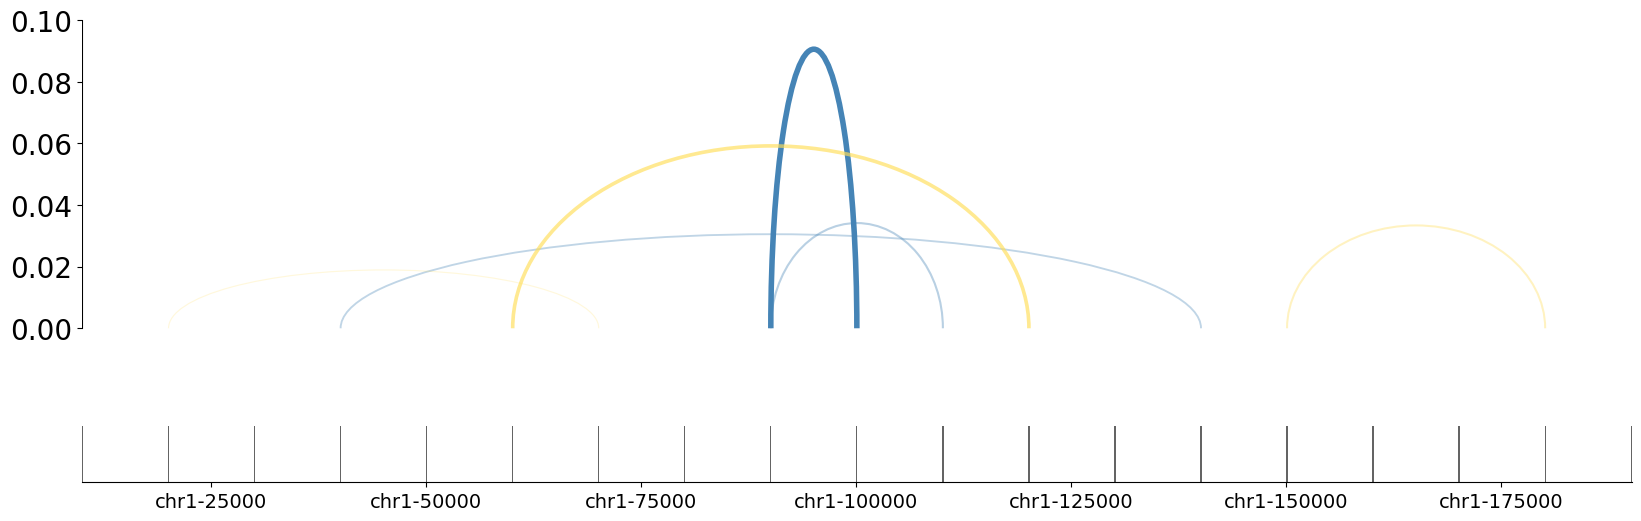

In [13]:
ci.plot_connections(
    circe_network,
    chromosome="chr1",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

### 6. Find cis-coaccessible connected modules

In addition to pairwise co-accessibility scores, Circe can also be used to <font color=#F98128>**define cis co-accessibility modules**</font> (called CCANs by Cicero), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.<br>
- The function `find_ccans` takes as input a `connection data frame` or the `anndata object` once again, and outputs a data frame with CCAN assignments for each input peak.<br>
- You can also use `add_ccans` to directly add CCAN assignments to your anndata object as `anndata.var['CCAN']`. The regions that aren't assigned to a CCAN will contain `None`.

In [14]:
ccans = ci.find_ccans(circe_network, seed=0)
ccans.head(3)

Coaccessibility cutoff used: 0.03
Number of CCANs generated: 132


,Peak,CCAN
0,chr3_3500001_3500151,1
1,chr3_3990001_3990151,1
2,chr3_3680001_3680151,1


In [15]:
atac = ci.add_ccans(atac)
atac.var.head()

Coaccessibility cutoff used: 0.03


,n_cells,chromosome,start,end,CCAN
chr1_1_151,268,chr1,1,151,1
chr1_10001_10151,260,chr1,10001,10151,None
chr1_20001_20151,266,chr1,20001,20151,1
chr1_30001_30151,249,chr1,30001,30151,None
chr1_40001_40151,254,chr1,40001,40151,1


With default `coaccess_cutoff_override=None`, the function will determine and report an appropriate co-accessibility score cutoff value for CCAN generation based on the number of overall CCANs at varying cutoffs. You can also set `coaccess_cutoff_override` to be a numeric between 0 and 1, to override the cutoff-finding part of the function. This option is useful if you feel that the cutoff found automatically was too strict or loose, or for speed if you are rerunning the code and know what the cutoff will be, since the cutoff finding procedure can be slow. 

In [16]:
ccans = ci.find_ccans(circe_network, seed=0, coaccess_cutoff_override=1e-7)

Coaccessibility cutoff used: 1e-07
Number of CCANs generated: 39


In [17]:
atac.var[atac.var['CCAN']==2].head(3)

,n_cells,chromosome,start,end,CCAN


In [18]:
atac.var['CCAN'].value_counts().head()

CCAN
17     28
128    25
48     16
79     15
88     13
Name: count, dtype: int64

#### 6.B. Plot only a CCAN module

If you're interested in a specific CCAN module, you can use `circe.draw.plot_ccan` function, precising its CCAN name. Only the connections between regions belonging to this CCAN module will be plotted.

This CCAN module is on the chromosome: chr1


/home/rtrimbou/miniconda3/envs/circe/lib/python3.12/site-packages/circe/circe.py:328: ImplicitModificationWarning: Setting element `.varp['atac_network']` of view, initializing view as actual.
  anndata.varp[key] = anndata.varp[key].tocoo()
/home/rtrimbou/miniconda3/envs/circe/lib/python3.12/site-packages/circe/draw.py:98: UserWarning: varp parameter is ignored for DataFrame input.
  warnings.warn(


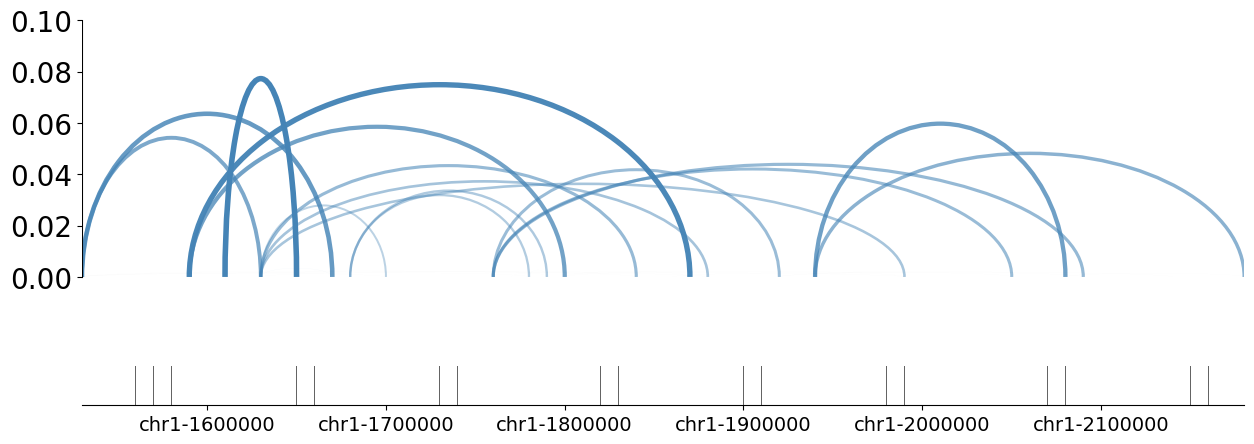

In [33]:
ci.draw.plot_ccan(
    atac,
    ccan_module=17,
    sep=('_', '_'),
    abs_threshold=0,
    figsize=(15,5),
    only_positive=True)

### 7. Work in progress! Happy to get feedbacks :)

If you feel any function could be useful for you on others, don't hesitate to write me at `remi.trimbour@pasteur.fr` or to submit an issue on `github.com/cantinilab/Circe`.